In [17]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score as sklearn_f1_score, jaccard_score


In [18]:
# Load the lung images and masks from the dataset

image_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/images"
mask_dir = r"/mnt/c/Users/prathana/Desktop/k-mam-seg/lung/masks"

# Function to load images and masks

def load_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    
    for img_file in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_file)
        mask_path = os.path.join(mask_dir, img_file)
        
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        
        img = cv2.resize(img, img_size)
        mask = cv2.resize(mask, img_size)
        
        img = np.expand_dims(img, axis=-1)
        mask = np.expand_dims(mask, axis=-1)
        
        images.append(img)
        masks.append(mask)
    
    images = np.array(images)
    masks = np.array(masks)
    
    return images, masks

images, masks = load_data(image_dir, mask_dir)

In [19]:
# Normalize images and masks

images = images / 255.0
masks = masks / 255.0

In [20]:
# Train-test split the dataset into training and validation sets

X_train, X_val, y_train, y_val = train_test_split(images, masks, test_size=0.2, random_state=42)


In [21]:
# Define a U-Net model for lung segmentation

def unet_model(input_size=(128, 128, 1)):
    inputs = Input(input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4], axis=-1)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = concatenate([UpSampling2D(size=(2, 2))(conv6), conv3], axis=-1)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2], axis=-1)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1], axis=-1)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])

    return model

model = unet_model()
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_76 (Conv2D)  │ (None, 128, 128,  │        640 │ input_layer_4[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_77 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_76[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 64, 64,    │          0 │ conv2d_77[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_78 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_16… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_79 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_78[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 32, 32,    │          0 │ conv2d_79[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_80 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_17… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_81 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_80[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_18    │ (None, 16, 16,    │          0 │ conv2d_81[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_82 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_18… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_83 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_82[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_19    │ (None, 8, 8, 512) │          0 │ conv2d_83[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_84 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_19… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_85 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_84[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_16    │ (None, 16, 16,    │          0 │ conv2d_85[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_16      │ (None, 16, 16,    │          0 │ up_sampling2d_16

 Total params: 31,377,793 (119.70 MB)

 Trainable params: 31,377,793 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# Define custom metric functions for evaluating the model performance

def dice_coefficient(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def f1_score(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))

def jaccard_index(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + K.epsilon()) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + K.epsilon())

model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=['accuracy', dice_coefficient, precision, recall, f1_score, jaccard_index])

In [23]:
# Train the U-net model

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50, batch_size=16)

Epoch 1/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.7446 - dice_coefficient: 0.3435 - f1_score: 0.1511 - jaccard_index: 0.2152 - loss: 1.4354 - precision: 0.2114 - recall: 0.1662 - val_accuracy: 0.8932 - val_dice_coefficient: 0.6904 - val_f1_score: 0.7559 - val_jaccard_index: 0.5275 - val_loss: 0.2498 - val_precision: 0.9148 - val_recall: 0.6455
Epoch 2/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - accuracy: 0.9146 - dice_coefficient: 0.7638 - f1_score: 0.8172 - jaccard_index: 0.6216 - loss: 0.1924 - precision: 0.8837 - recall: 0.7722 - val_accuracy: 0.9530 - val_dice_coefficient: 0.8781 - val_f1_score: 0.9038 - val_jaccard_index: 0.7831 - val_loss: 0.0987 - val_precision: 0.8972 - val_recall: 0.9109
Epoch 3/50
181/181 ━━━━━━━━━━━━━━━━━━━━ 15s 82ms/step - accuracy: 0.9573 - dice_coefficient: 0.8945 - f1_score: 0.9112 - jaccard_index: 0.8096 - loss: 0.0873 - precision: 0.9262 - recall: 0.8982 - val_accuracy: 0.9654 - val_dice_coefficient: 0.9179 - val_f1_score: 0.9307 

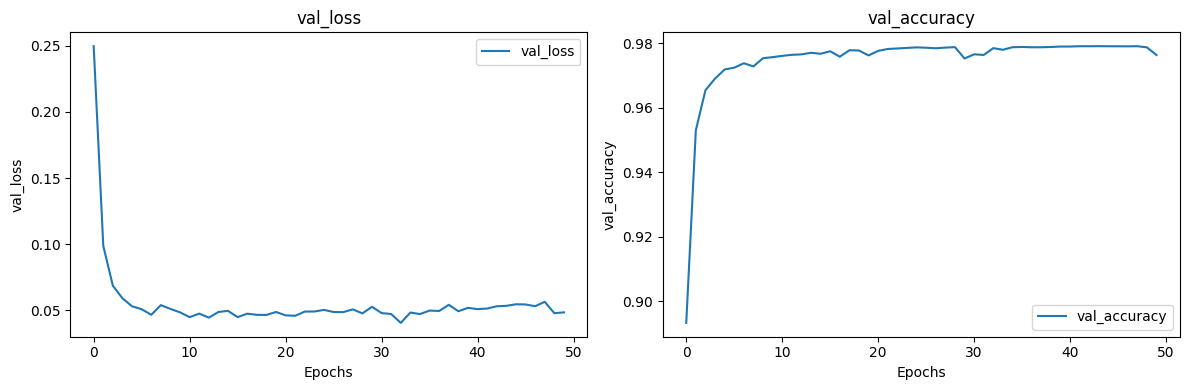

In [27]:
# Plot the validation accuracy and validation loss

def plot_val_metrics(history):
    metrics = ['val_loss', 'val_accuracy']
    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 2, i + 1)
        plt.plot(history.history[metric], label=metric)
        plt.title(metric)
        plt.xlabel('Epochs')
        plt.ylabel(metric)
        plt.legend()

    plt.tight_layout()
    plt.show()

plot_val_metrics(history)

In [26]:
# Predict on validation data

preds = model.predict(X_val)

23/23 ━━━━━━━━━━━━━━━━━━━━ 184s 6s/step


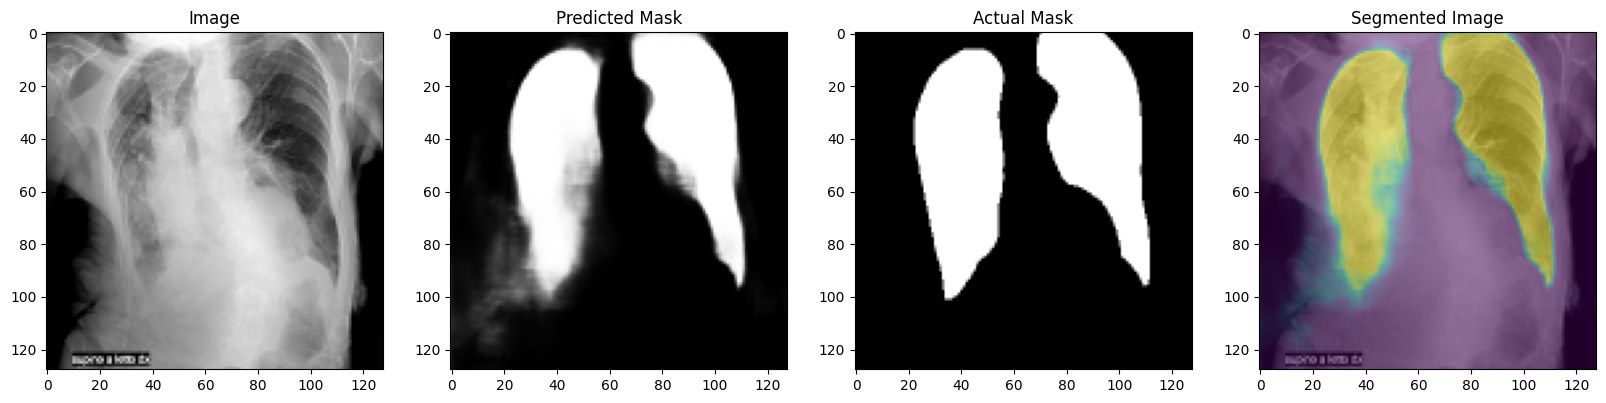

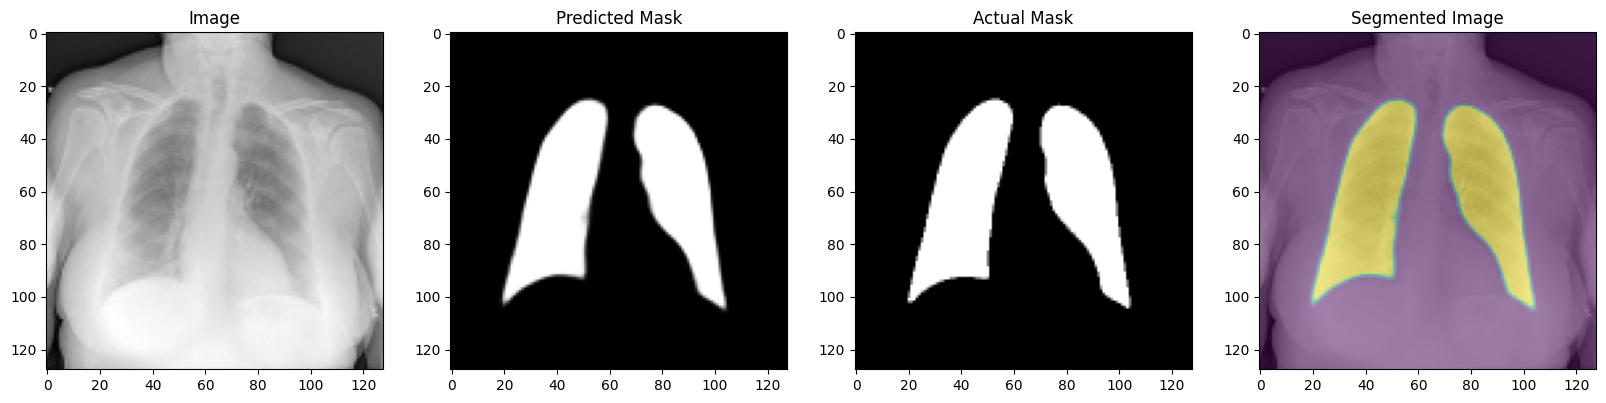

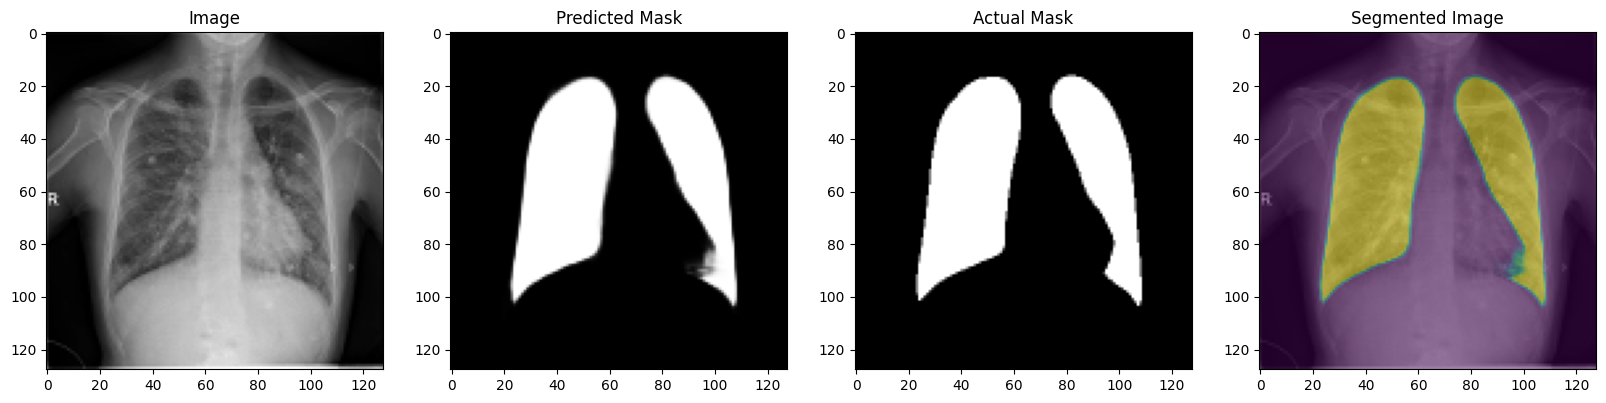

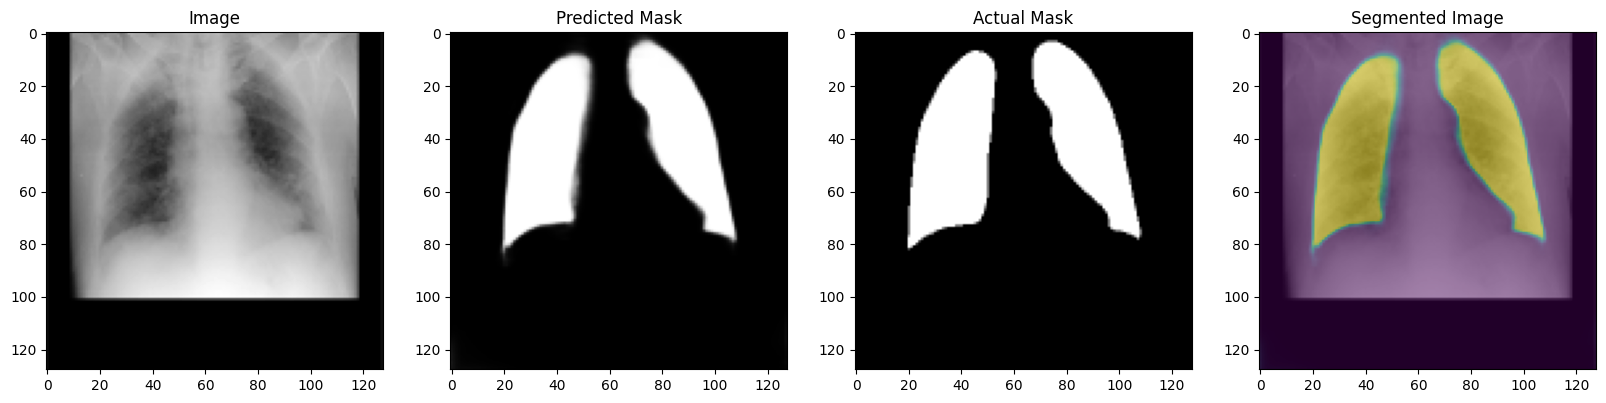

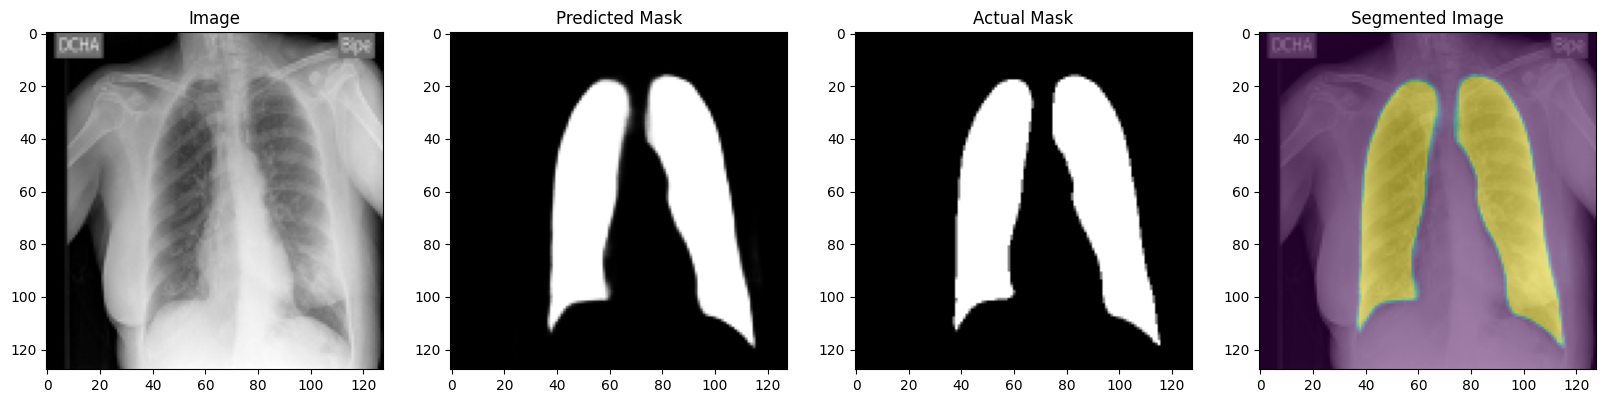

In [28]:
# Visualize the results

def plot_sample(image, mask, pred_mask):
    fig, axs = plt.subplots(1, 4, figsize=(20, 5))
    axs[0].imshow(image.squeeze(), cmap='gray')
    axs[0].set_title('Image')
    axs[1].imshow(pred_mask.squeeze(), cmap='gray')
    axs[1].set_title('Predicted Mask')
    axs[2].imshow(mask.squeeze(), cmap='gray')
    axs[2].set_title('Actual Mask')
    axs[3].imshow(image.squeeze(), cmap='gray')
    axs[3].imshow(pred_mask.squeeze(), alpha=0.5)
    axs[3].set_title('Segmented Image')
    plt.show()

# Display a few samples

for i in range(5):
    plot_sample(X_val[i], y_val[i], preds[i])


In [29]:
# Ensure y_val contains binary values

y_val_binary = (y_val > 0.5).astype(int)

# Flatten the arrays for metric calculation

y_val_flat = y_val_binary.flatten()
val_preds_binary_flat = val_preds_binary.flatten()

# Calculate metrics

val_accuracy = accuracy_score(y_val_flat, val_preds_binary_flat)
val_precision = precision_score(y_val_flat, val_preds_binary_flat)
val_recall = recall_score(y_val_flat, val_preds_binary_flat)
val_f1_score = sklearn_f1_score(y_val_flat, val_preds_binary_flat)
val_jaccard_index = jaccard_score(y_val_flat, val_preds_binary_flat)

# Dice coefficient is often computed using the F1 score for binary classification problems

val_dice_coefficient = 2 * (val_precision * val_recall) / (val_precision + val_recall)

print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation Precision: {val_precision:.4f}")
print(f"Validation Recall: {val_recall:.4f}")
print(f"Validation F1 Score: {val_f1_score:.4f}")
print(f"Validation Jaccard Index: {val_jaccard_index:.4f}")
print(f"Validation Dice Coefficient: {val_dice_coefficient:.4f}")


Validation Accuracy: 0.9715
Validation Precision: 0.9506
Validation Recall: 0.9350
Validation F1 Score: 0.9427
Validation Jaccard Index: 0.8916
Validation Dice Coefficient: 0.9427


In [30]:
# Displaying all the metrics in percentage

val_accuracy_percent = val_accuracy * 100
val_precision_percent = val_precision * 100
val_recall_percent = val_recall * 100
val_f1_score_percent = val_f1_score * 100
val_jaccard_index_percent = val_jaccard_index * 100
val_dice_coefficient_percent = val_dice_coefficient * 100

print(f"Validation Accuracy: {val_accuracy_percent:.2f} %")
print(f"Validation Precision: {val_precision_percent:.2f} %")
print(f"Validation Recall: {val_recall_percent:.2f}%")
print(f"Validation F1 Score: {val_f1_score_percent:.2f} %")
print(f"Validation Jaccard Index: {val_jaccard_index_percent:.2f} %")
print(f"Validation Dice Coefficient: {val_dice_coefficient_percent:.2f} %")

Validation Accuracy: 97.15 %
Validation Precision: 95.06 %
Validation Recall: 93.50%
Validation F1 Score: 94.27 %
Validation Jaccard Index: 89.16 %
Validation Dice Coefficient: 94.27 %
